In [1]:
import os
import time
import winsound
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization, LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
import glob
#tf.config.optimizer.set_jit(False)
tf.random.set_seed(42)

In [2]:
# print(tf.config.list_physical_devices('GPU'))
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     tf.config.set_visible_devices(gpus[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# # Limit GPU memory growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         print("GPU memory growth enabled")
#     except RuntimeError as e:
#         print(e)

# # Limit GPU memory usage to 80%
# if gpus:
#     try:
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=1024*8)]  # Limit to 8GB
#         )
#     except RuntimeError as e:
#         print(e)

GPU memory growth enabled


In [4]:
base_path = 'dataset/'
train_dir = os.path.join(base_path, 'train')

train_csv = os.path.join(base_path, 'train', '_annotations.csv')
valid_csv = os.path.join(base_path, 'valid', '_annotations.csv')
test_csv = os.path.join(base_path, 'test', '_annotations.csv')
                        
# Function to load and preprocess images
def load_and_preprocess_image(filename, label, bbox):
    try:
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [360, 360])  # VGG16 input size
        img = tf.cast(img, tf.float32)  / 255.0
        #img = tf.keras.applications.vgg16.preprocess_input(img)
        return img, label, bbox
    except tf.errors.NotFoundError:
        print(f"File not found: {filename}")
        return None, None, None

# Function to load data from CSV and create a dataset
def create_dataset(csv_file, base_dir, is_training=True):
    df = pd.read_csv(csv_file)
    unique_labels = df['class'].unique()
    print(unique_labels)
    
    # Encode class labels
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    filenames = df['filename'].apply(lambda x: os.path.join(base_dir, x)).values
    labels = df['class'].values
    labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=len(le.classes_))
    bboxes = df[['xmin', 'ymin', 'xmax', 'ymax']].values.astype(np.float32)
    
    print(f"Base Dir: {base_dir}")
    print(f"Labels shape before one-hot encoding: {labels.shape}")
    print(f"Labels shape after one-hot encoding: {labels_one_hot.shape}")    
    print(f"Bounding boxes shape: {bboxes.shape}")
    print(f"Number of classes: {len(le.classes_)}")
    print()
    
    # Create the initial dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels_one_hot, bboxes))
    
    # Modified map function to return the correct format
    def prepare_data(filename, label, bbox):
        img, label, bbox = load_and_preprocess_image(filename, label, bbox)
        return img, {'class_output': label, 'bbox_output': bbox}
    
    # Apply the mapping
    dataset = dataset.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda x, y: x is not None)  # Modified filter
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(16)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset, le
# Also modify the load_and_preprocess_image function to handle None cases properly
def load_and_preprocess_image(filename, label, bbox):
    try:
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [360, 360])  # VGG16 input size
        img = tf.cast(img, tf.float32) / 255.0
        return img, label, bbox
    except tf.errors.NotFoundError:
        print(f"File not found: {filename}")
        return None, None, None

# Create datasets
train_dataset, label_encoder = create_dataset(train_csv, os.path.join(base_path, 'train'))
valid_dataset, _ = create_dataset(valid_csv, os.path.join(base_path, 'valid'), is_training=False)
test_dataset, _ = create_dataset(test_csv, os.path.join(base_path, 'test'), is_training=False)

# Verify the dataset structure
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape)
    print("Class output shape:", labels['class_output'].shape)
    print("Bbox output shape:", labels['bbox_output'].shape)

['ShotGun' 'Rifle' 'SMG' 'HandGun']
Base Dir: dataset/train
Labels shape before one-hot encoding: (200,)
Labels shape after one-hot encoding: (200, 4)
Bounding boxes shape: (200, 4)
Number of classes: 4

['ShotGun' 'Rifle' 'SMG' 'HandGun']
Base Dir: dataset/valid
Labels shape before one-hot encoding: (200,)
Labels shape after one-hot encoding: (200, 4)
Bounding boxes shape: (200, 4)
Number of classes: 4

['SMG' 'ShotGun' 'HandGun' 'Rifle']
Base Dir: dataset/test
Labels shape before one-hot encoding: (467,)
Labels shape after one-hot encoding: (467, 4)
Bounding boxes shape: (467, 4)
Number of classes: 4

Images shape: (16, 360, 360, 3)
Class output shape: (16, 4)
Bbox output shape: (16, 4)


In [5]:

# Create a custom VGG16 model without pre-trained weights
base_model = VGG16(weights=None, include_top=False, input_shape=(360, 360, 3))

# Make some layers non-trainable
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Input layer
inputs = Input(shape=(360, 360, 3))

# VGG16 base model
base_model = VGG16(weights=None, include_top=False, input_shape=(360, 360, 3))
x = base_model(inputs, training=True)

#Custom Convolutional Block 1
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Custom Convolutional Block 2
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Global average pooling after the custom convolutional layers
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(512)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.4)(x)

x = Dense(64)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

# Output layers
# Layer 24: Output layer for class predictions
class_output = Dense(4, activation='softmax', name='class_output')(x)

# Layer 25: Output layer for bounding box regression
bbox_output = Dense(4, name='bbox_output')(x)

# Create the final model
model = Model(inputs=inputs, outputs=[class_output, bbox_output])

# Compile the model
optimizer = AdamW(learning_rate=0.0001, weight_decay=0.0001)
model.compile(optimizer=optimizer,
              loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
              loss_weights={'class_output': 1.0, 'bbox_output': 1.0},
              metrics={'class_output': 'accuracy','bbox_output': 'mae'})

# Modified callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # This monitors the total validation loss
    factor=0.5,
    patience=5,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # This monitors the total validation loss
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Modified checkpoint callback
checkpoint = ModelCheckpoint(
    'model/epoch_{epoch:02d}_loss_{loss:.2f}.keras',  # Changed from val_loss to loss
    # OR use this alternative format:
    # 'model/epoch_{epoch:02d}.keras',  # Simpler format without loss value
    monitor='val_loss',
    save_best_only=True,  # Changed to True to save only the best model
    verbose=1,
    save_weights_only=False
)

# Summary of the model
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 360, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 11, 11, 512)  14714688    ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 11, 11, 64)   294976      ['vgg16[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 11, 11, 64)  256         ['conv2d[0][0]']             

In [6]:
# Model training
history = model.fit(train_dataset,
                    epochs=100,  # Adjust based on convergence
                    validation_data=valid_dataset,
                    callbacks=[lr_scheduler, early_stopping, checkpoint])



Epoch 1/100


NotFoundError: Graph execution error:

Detected at node 'model/vgg16/block1_conv1/Relu' defined at (most recent call last):
    File "c:\Users\choud\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\choud\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\choud\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\choud\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\choud\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\choud\AppData\Local\Temp\ipykernel_20464\4283774387.py", line 2, in <module>
      history = model.fit(train_dataset,
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\choud\miniconda3\envs\tf\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/vgg16/block1_conv1/Relu'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 0#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 2#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 2: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 6#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 6: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 5#TC: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 5: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 7#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 7: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
	 [[{{node model/vgg16/block1_conv1/Relu}}]] [Op:__inference_train_function_7694]

In [6]:
model.save('model/final_model.keras')

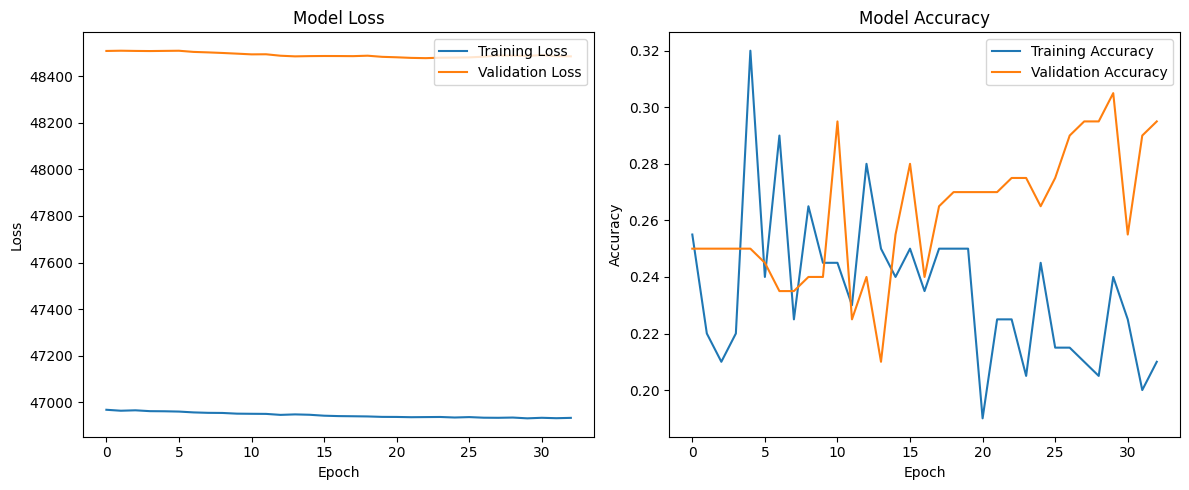

In [11]:
# Assuming you've already trained your model and stored history in a variable 'history'
# Plot training & validation loss values
def plot_metrics(history):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Call this function after your model has been trained
plot_metrics(history)


30/30 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step


C:\Users\choud\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Classification Report:


d:\testing\.testenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\testing\.testenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\testing\.testenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     HandGun       0.40      0.01      0.03       143
       Rifle       0.00      0.00      0.00       150
         SMG       0.17      0.87      0.29        83
     ShotGun       0.24      0.13      0.17        91

    accuracy                           0.18       467
   macro avg       0.20      0.25      0.12       467
weighted avg       0.20      0.18      0.09       467



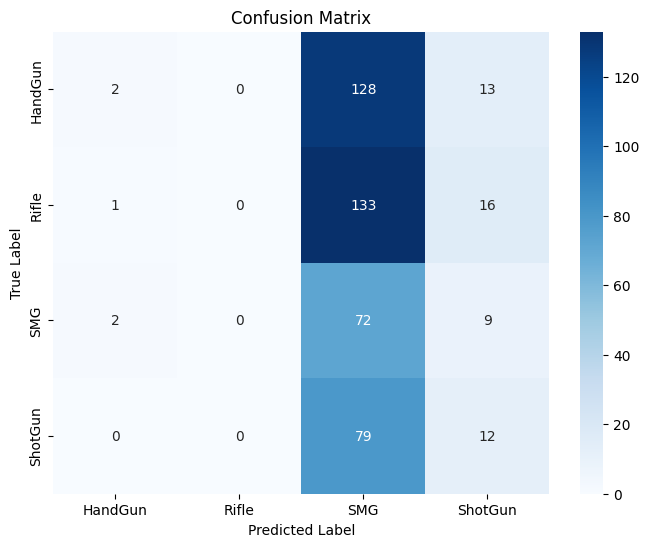

In [12]:
# Predictions on test data
class_pred, bbox_pred = model.predict(test_dataset)
class_pred_labels = np.argmax(class_pred, axis=1)

# Extract true class labels from test dataset
true_class_labels = []
for images, labels in test_dataset.unbatch():
    true_class_labels.append(np.argmax(labels['class_output']))

true_class_labels = np.array(true_class_labels)

# Classification report
print("Classification Report:")
print(classification_report(true_class_labels, class_pred_labels, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_class_labels, class_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
